<a href="https://colab.research.google.com/github/SergioJF10/MLT-ESI-UCLM_CIS/blob/main/products/Notebooks/Models/TF_IDF_and_POS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-IDF Vectorization and POS Tagging
In this colab, we will develop another approach, including the TF-IDF vectorization as well as a POS tagging. 

We want to highlight that we did not include the N-grams due to its high memory demanding aspect.

In [24]:
%%capture
!pip install nltk
import nltk
nltk.download("popular")
import json
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Tecniques/Natural Language Processing/products.csv' 'products.csv'
!cp '/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Tecniques/Natural Language Processing/x_train.json' 'x_train.json'
!cp '/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Tecniques/Natural Language Processing/y_train.json' 'y_train.json'
!cp '/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Tecniques/Natural Language Processing/x_test.json' 'x_test.json'
!cp '/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Tecniques/Natural Language Processing/y_test.json' 'y_test.json'

Mounted at /content/gdrive


# 0. Loading the Data
From the Preprocessing notebook, we obtain the following files with the data ready to be vectorized.
- x_train.json
- x_test.json
- y_train.json
- y_test.json

_Note: Please upload those four files. They can be found in the "Data/Interim" folder in the `products` project folder._

In [3]:
x_train = []
x_test = []
y_train = []
y_test = []
with open('x_train.json', 'r', encoding='utf-8') as x_train_file:
  x_train = json.load(x_train_file)
with open('x_test.json', 'r', encoding='utf-8') as x_test_file:
  x_test = json.load(x_test_file)
with open('y_train.json', 'r', encoding='utf-8') as y_train_file:
  y_train = json.load(y_train_file)
with open('y_test.json', 'r', encoding='utf-8') as y_test_file:
  y_test = json.load(y_test_file)

Once the file descriptors have been used, we will delete them to save RAM.

In [4]:
del x_test_file
del x_train_file
del y_test_file
del y_train_file

# 1. TF-IDF Vectorization and POS Tagging
Let's now apply vectorization techniques over the preprocessed data in order to prepare the input for the models.

We apply the TFIDF vectorization over both, the train and the test sets according to the vocabulary from all the documents.

In [5]:
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
vectorizer.fit(x_train + x_test)
x_train_tfidf = vectorizer.transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

Once we have obtained the TFIDF vectorization, we have to get rid of a 70% of the total features, so, we need the best 30% of the whole list of features, let's call it $k$.

In [6]:
k = int(0.3*x_train_tfidf.shape[1])
print(k)

15542


Let's now select the most important features for bot train and test sets.

In [7]:
selector = SelectKBest(score_func=chi2, k=k)
x_train_tfidf = selector.fit_transform(x_train_tfidf, y_train)
x_test_tfidf = selector.transform(x_test_tfidf)
print(x_train_tfidf.shape[1])

15542


We should highlight that, originally, the different results should be stored in different variables but, due to the huge memory consumed per each variable, we will use just one variable.

Now, we store both of them in a pandas dataframe to apply the pertinent transformations.

In [9]:
x_train_tfidf = pd.DataFrame(data=x_train_tfidf.toarray())
x_test_tfidf = pd.DataFrame(data=x_test_tfidf.toarray())

In [10]:
x_train_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,15532,15533,15534,15535,15536,15537,15538,15539,15540,15541
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Wow, let's try to add some information from the **POS tagging**. In our case, the most appropriate would be the number of adjectives, since, the more adjectives in a review, the more information about the product it has.

Please note that the process for both, the train and test data might take a while.

In [25]:
pos_array = []

def n_adjs(pos_tags):
  number = 0
  for tag in pos_tags:
    if tag[1] == 'JJ': # Adjectives
      number += 1
  return number

for voc in tqdm(x_train):
  pos_tags = nltk.pos_tag(voc.split(' '))
  pos_array.append(n_adjs(pos_tags))

print(len(pos_array))

100%|██████████| 35414/35414 [02:04<00:00, 284.98it/s]

35414


In [26]:
pos_test = []
for voc in tqdm(x_test):
  pos_tags = nltk.pos_tag(voc.split(' '))
  pos_test.append(n_adjs(pos_tags))

  1%|          | 96/15178 [00:00<00:35, 421.43it/s]

In [29]:
x_train_tfidf['n_adjs'] = pos_array
x_test_tfidf['n_adjs'] = pos_test

Now, it's time to train our first model, a Naive Bayes model with a Multinomial approach, since it is the most appropriate for our case.

In [31]:
mngb_model = MultinomialNB().fit(x_train_tfidf, y_train)
preds = mngb_model.predict(x_test_tfidf)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy for the model: 0.6191197786269601


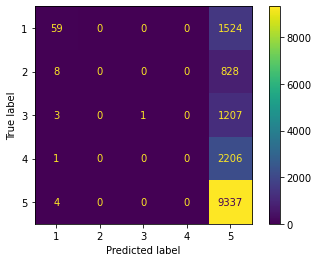

In [34]:
print(f'Accuracy for the model: {f1_score(y_test, preds, average="micro")}')

cm = confusion_matrix(y_test, list(preds), labels=mngb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mngb_model.classes_) 
disp.plot()
plt.show()